# Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Инструкция по выполнению проекта

Загрузите данные и выполните их ресемплирование по одному часу.
Проанализируйте данные.
Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
Проверьте данные на тестовой выборке и сделайте выводы.

In [ ]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

import warnings

warnings.filterwarnings('ignore')

In [2]:
try:
    
    df = pd.read_csv('/Users/admin/Desktop/Rudra PRACTICUM/Projects/my_project/Datasets/taxi.csv')
    
except:
    
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df['datetime'] = df.datetime.apply(pd.to_datetime)

In [6]:
df.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
df.datetime.min()

Timestamp('2018-03-01 00:00:00')

In [8]:
df.datetime.max()

Timestamp('2018-08-31 23:50:00')

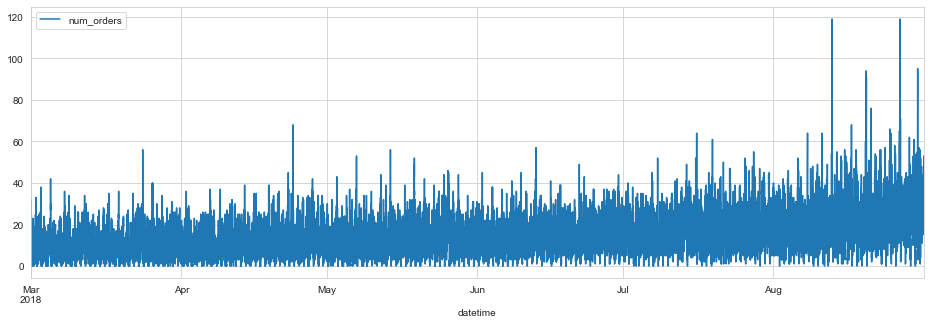

In [9]:
sns.set_style('whitegrid')
df.plot(x='datetime', y='num_orders', figsize=(16, 5));

### Выполняю ресемплирование

In [10]:
df.set_index('datetime', inplace=True)

In [11]:
print(df.index.is_monotonic)

True


In [12]:
df_1H = df.resample('1H').sum()

### Проанализирую данные.

In [13]:
df_1H

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [14]:
decomposed = seasonal_decompose(df_1H)

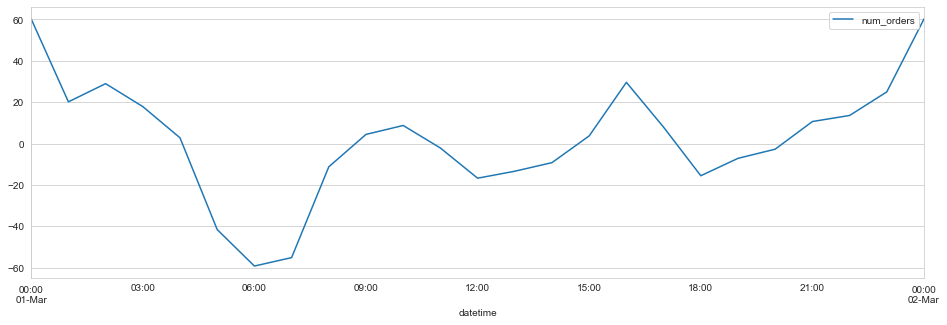

In [15]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot(figsize=(16, 5));

#### Видим ежедневную сезонность(цекличность)

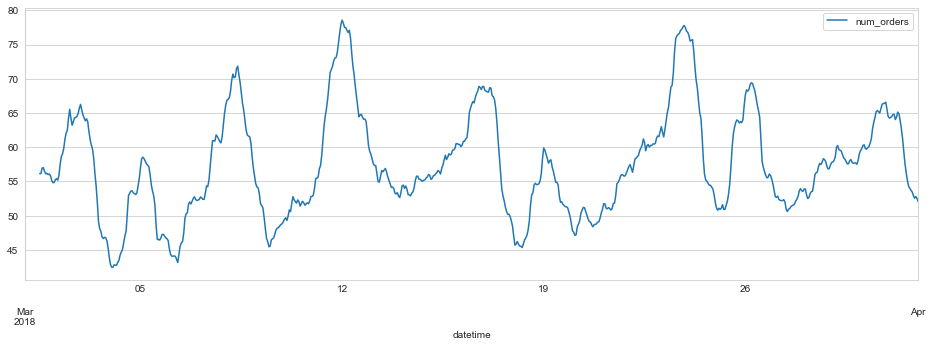

In [16]:
decomposed.trend['2018-03-01 00:00:00':'2018-04-01 00:00:00'].plot(figsize=(16, 5));

#### Видим рост увелечения заказов ближе к осени

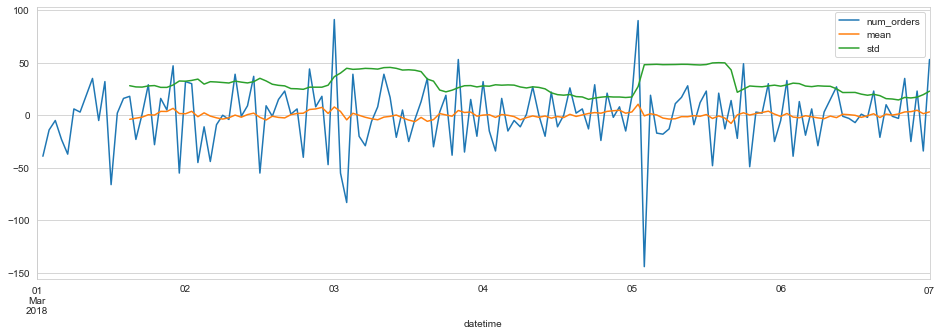

In [17]:
df_plot = df_1H - df_1H.shift()
df_plot['mean'] = df_plot['num_orders'].rolling(15).mean()
df_plot['std'] = df_plot['num_orders'].rolling(15).std()
df_plot['2018-03-01 00:00:00':'2018-03-07 00:00:00'].plot(figsize=(16, 5));

### Строю модель

###  Создание признаков

In [18]:
best_model = None
best_result = 10000
best_lag = 0
best_rolling_mean_size = 0

for lag in range(1, 200 + 1):
    for rolling_mean_size in range (1, 10):
        df_1H['rolling_mean'] = df_1H['num_orders'].shift().rolling(rolling_mean_size).mean()
        df_1H['lag_{}'.format(lag)] = df_1H['num_orders'].shift(lag)
        train, test=train_test_split(df_1H, shuffle=False, test_size=0.1)
        train=train.dropna()
        train, valid = train_test_split(train, shuffle=False, test_size=0.1)
        features_train = train.drop('num_orders', 1)
        target_train = train.num_orders
        features_valid = valid.drop('num_orders', 1)
        target_valid = valid.num_orders
        features_test = test.drop('num_orders', 1)
        target_test = test.num_orders
        model = LinearRegression()
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        result = mean_squared_error(target_valid, predictions_valid ) ** 0.5
        if result < best_result:
            best_model = model
            best_result = result
            best_lag = lag
            best_rolling_mean_size = rolling_mean_size

In [19]:
print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество лагов:", best_lag, "Максимальное окно:", best_rolling_mean_size)

RMSE наилучшей модели на валидационной выборке: 28.013183364943583 Количество лагов: 169 Максимальное окно: 2


### Линейная регрессия

In [20]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predictions_valid = model_lr.predict(features_valid) 
result = mean_squared_error(target_valid, predictions_valid ) ** 0.5

In [21]:
print("RMSE наилучшей модели на валидационной выборке:", result)

RMSE наилучшей модели на валидационной выборке: 28.283382656578617


### CatBoost

In [22]:
best_model_cb = None
best_result = 10000
best_est = 0
best_depth = 0

for est in range(1, 100, 10):
    for depths in range (1, 11):
        model = CatBoostRegressor(random_state=12345, iterations=est, depth=depths, loss_function='RMSE', verbose=False)
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        result = mean_squared_error(target_valid, predictions_valid ) ** 0.5
        if result < best_result:
            best_model_cb = model
            best_result = result
            best_est = est
            best_depth = depths

In [23]:
print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

RMSE наилучшей модели на валидационной выборке: 28.49027319450912 Количество деревьев: 61 Максимальная глубина: 4


### Решающие дерево

In [24]:
best_model_dt = None
best_result = 0
best_depth = 0
for depth in range(1, 20):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid ) ** 0.5
    if result > best_result:
        best_model_dt = model
        best_result = result
        best_depth = depth

In [25]:
print("RMSE наилучшей модели на валидационной выборке:", best_result, "Максимальная глубина:", best_depth)

RMSE наилучшей модели на валидационной выборке: 44.334400591520875 Максимальная глубина: 1


### LGBMRegressor

In [26]:
best_model_LGBM = None
best_result = 10000
best_est = 0
best_depth = 0

for est in range(1, 100, 10):
    for depth in range (1, 10):
        model = LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        result = mean_squared_error(target_valid, predictions_valid ) ** 0.5
        if result < best_result:
            best_model_LGBM = model
            best_result = result
            best_est = est
            best_depth = depth

In [27]:
print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

RMSE наилучшей модели на валидационной выборке: 29.104393106052687 Количество деревьев: 71 Максимальная глубина: 7


# Вывод: наилучшей моделью считаю линейную регрессию с небольшим отстованием CatBoost затем LGBM и на последнем месте дерево решений

### Проверяемм тестовые выборки

### Линейная регрессия

In [29]:
predictions_test = model_lr.predict(features_test) 
result = mean_squared_error(target_test, predictions_test ) ** 0.5
print(f'RMSE на тестовой выборке LinearRegressor = {result}')

RMSE на тестовой выборке LinearRegressor = 34.61786036249104


### CatBoost

In [30]:
predictions_test = best_model_cb.predict(features_test) 
result = mean_squared_error(target_test, predictions_test ) ** 0.5
print(f'RMSE на тестовой выборке CatBoost = {result}')

RMSE на тестовой выборке CatBoost = 42.03042638152255


### DecisionTree

In [31]:
predictions_test = best_model_dt.predict(features_test) 
result = mean_squared_error(target_test, predictions_test ) ** 0.5
print(f'RMSE на тестовой выборке DecisionTree = {result}')

RMSE на тестовой выборке DecisionTree = 68.59900322438197


### LGBM

In [32]:
predictions_test = best_model_LGBM.predict(features_test) 
result = mean_squared_error(target_test, predictions_test ) ** 0.5
print(f'RMSE на тестовой выборке LGBM = {result}')

RMSE на тестовой выборке LGBM = 40.7663025514533
